In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.stats.mstats import mquantiles
from  scipy.optimize import curve_fit as fit


import sys
import os
sys.path.append(os.path.abspath('../Backend'))

import wahlrecht_polling_firms
import model_helper
%matplotlib inline

In [2]:
complete_data_dict = wahlrecht_polling_firms.get_tables()
data = complete_data_dict['allensbach']

In [3]:
class predict_till_election ():
    '''
    Each model gives 2 outputs: the traces for the parties, and the quantiles at 5%, 50% and 95%.
    **kwargs : "weeks" how many weeks back in the past are used
    
    '''
    
    def __init__ (self, timeline = data, predict_f = 'montecarlo'):
        self.timeline = timeline
        self.funcs_dict = {'montecarlo': self.montecarlo,
                           'linear': self.linear,
                           'quadratic': self.quadratic}
        self.predict_f = self.funcs_dict[predict_f]
        self.election_date = pd.to_datetime('24.09.2017') #dt.date.strptime('24.09.2017', '%d.%m.%Y')
        self.weeks_left(timeline)
        self.parties  = model_helper.parties
    
    def predict(self, **kwargs):
        self.predict_f(**kwargs)
        
    def weeks_left(self, timeline):
        most_recent_poll = self.election_date  - pd.to_datetime (timeline['Datum']) #TODO: make sure it's always "Datum"
        
        self.weeks = int((most_recent_poll).astype('timedelta64[W]')[0])
    
    def montecarlo(self, iterations = 1000, **kwargs):
        print ((iterations,self.weeks,len(self.parties)))
        self.traces = np.empty ((iterations,self.weeks,len(self.parties)))
        
        covar = self.timeline[self.parties].cov()

        for i in range(iterations):
            self.traces[i] =self.n_weeks_predict(covar)
            if (100*i/iterations) == int ((100*i/iterations)):
                print ("\r %d" %(100*i/iterations), end = '')
        self.quantiles = [mquantiles(test.traces[:,:,i], prob = (0.05,0.5,0.95), axis= 0) for i in range(len(self.parties))]


    def n_weeks_predict (self, covar):
        trace = np.empty((self.weeks,len(self.parties)))
        
        props = self.timeline[self.parties].iloc[0]
        trace [0] = props
        
        for i in range (1,self.weeks):
            props+=np.random.multivariate_normal(np.zeros(len(self.parties)) , covar)
            props[props<0]=0
            props= props/(props.sum()) *100
            trace[i] = props
        return trace
    
    def linear (self,**kwargs):
        # TODO : make sure that the self.quantiles is getting 3 point as a prediction for 
        #the linear model for each party for each time point, it works with .reshape(len(self.parties),1)
        self.traces = None
        self.quantiles = np.tile(self.timeline.iloc[0][self.parties].reshape(len(self.parties),3,1), (1,self.weeks))
        
    def quadratic (self, **kwargs):
        if 'weeks' in kwargs:
            weeks = kwargs['weeks']
        else :
            weeks = -1
            
        popts = np.zeros((3, len(self.timeline.iloc[:weeks])))
        quad = lambda x,a,b,c : a +x*b+ c*x**2  
        self.traces = []
        for ind, party in enumerate( self.parties):
            popt, pcovs = fit(quad,np.arange(len(self.timeline.iloc[:weeks][party])),self.timeline.iloc[:weeks][party])

            self.traces.append(quad(np.arange(-self.weeks,len(self.timeline[party])),*popt) )

In [31]:
test = predict_till_election(predict_f='montecarlo')

In [32]:
test.predict(iterations=100)

(100, 13, 7)
 8

/home/tamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: covariance is not positive-semidefinite.


 99

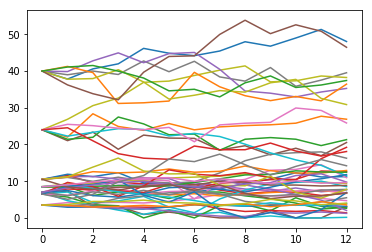

In [33]:
for i in range (7):
    plt.plot(test.traces[i][:])